In [1]:
%matplotlib inline

In [2]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

In [3]:
import matplotlib.pyplot as plt

## **DataSet**

In [4]:
num_inputs=200

In [5]:
w = torch.ones((num_inputs, 1)) * 0.01
w

tensor([[0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0.0100],
        [0

In [6]:
b = 0.05

In [7]:
batch_size = 5

In [8]:
num_train = 20

X_train = torch.normal(0, 1, (num_train, num_inputs))
y_train = torch.matmul(X_train, w) + b + torch.normal(0, 0.01, (num_train, 1))

train_ds = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

In [9]:
num_val = 100

X_val = torch.normal(0, 1, (num_val, num_inputs))
y_val = torch.matmul(X_val, w) + b + torch.normal(0, 0.01, (num_val, 1))

val_ds = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

## **Functions**

In [10]:
class LinearRegression(nn.Module):
    def __init__(self,num_inputs, lr):
        super().__init__()
        self.lr = lr
        self.net = nn.Linear(num_inputs, 1)
        self.net.weight.data.normal_(0, 0.01)
        self.net.bias.data.fill_(0)

    def forward(self, X):
        return self.net(X)

In [11]:
def train(lambd):
    model = LinearRegression(num_inputs=num_inputs, lr=0.01)
    # for param in model.parameters():
    #     print(param)

    optimizer = torch.optim.SGD(params=model.parameters(), lr=model.lr)

    mse = nn.MSELoss()
    def criterion(y_hat, y, w, lambd):
        return mse(y_hat, y) + lambd * (w ** 2).sum() / 2

    list_train_loss = []
    list_val_loss = []
    
    num_epochs = 10
    for i in range(num_epochs):
        model.train()
    
        num_train_batches = 0
        train_loss = 0
        for X, y in train_loader:
            optimizer.zero_grad()
            w = model.net.weight  # .data까지 하면 gradient 추적 깨짐
            y_hat = model(X)
            loss = criterion(y_hat, y, w, lambd)
            loss.backward()   # loss를 parameter로 미분해라 → w.grad, b.grad 값 생김
            optimizer.step()  # 계산한 gradient에 따라 parameter를 업데이트해라
    
            num_train_batches += 1
            train_loss += loss.item()  # 값만 가져와라
            
        model.eval()
    
        num_val_batches = 0
        val_loss = 0
        with torch.no_grad():
            for X, y in val_loader:
                y_hat = model(X)
                loss = mse(y_hat, y)
    
                num_val_batches += 1
                val_loss += loss.item()
    
        list_train_loss.append(train_loss/num_train_batches)
        list_val_loss.append(val_loss/num_val_batches)
        # print(f'epoch {i:02d} train_loss={train_loss/num_train_batches:.4f} val_loss={val_loss/num_val_batches:.4f}')

    plt.figure(figsize=(5, 3))
    plt.plot(list_train_loss, label='train')
    plt.plot(list_val_loss, label='valid', linestyle='--')
    plt.legend()
    plt.title(f'$\lambda$={lambd}')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.yscale('log')
    plt.show()

    return model

## **Training without Regularization**

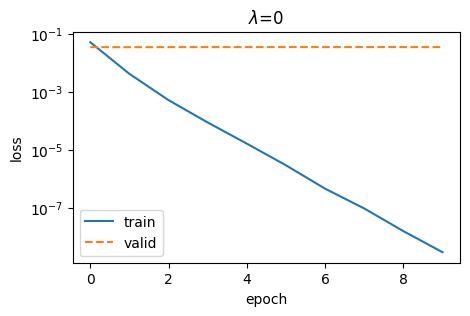

In [12]:
model_without = train(0)

In [13]:
(model_without.net.weight.data ** 2).sum()

tensor(0.0207)

## **Training with Regularization**

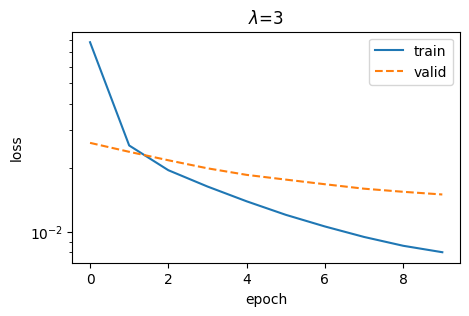

In [14]:
model_with = train(3)

In [15]:
(model_with.net.weight.data ** 2).sum()

tensor(0.0046)

## **Optimizer에 바로 Weight Decay 때리기**

In [16]:
def train(lambd):
    model = LinearRegression(num_inputs=num_inputs, lr=0.01)
    # for param in model.parameters():
    #     print(param)

    optimizer = torch.optim.SGD(
        params=[
            {'params': model.net.weight, 'weight_decay': lambd},
            {'params': model.net.bias}
            ],
        lr=model.lr
    )

    mse = nn.MSELoss()
    def criterion(y_hat, y, w, lambd):
        return mse(y_hat, y) + lambd * (w ** 2).sum() / 2

    list_train_loss = []
    list_val_loss = []
    
    num_epochs = 10
    for i in range(num_epochs):
        model.train()
    
        num_train_batches = 0
        train_loss = 0
        for X, y in train_loader:
            optimizer.zero_grad()
            w = model.net.weight  # .data까지 하면 gradient 추적 깨짐
            y_hat = model(X)
            loss = criterion(y_hat, y, w, lambd)
            loss.backward()   # loss를 parameter로 미분해라 → w.grad, b.grad 값 생김
            optimizer.step()  # 계산한 gradient에 따라 parameter를 업데이트해라
    
            num_train_batches += 1
            train_loss += loss.item()  # 값만 가져와라
            
        model.eval()
    
        num_val_batches = 0
        val_loss = 0
        with torch.no_grad():
            for X, y in val_loader:
                y_hat = model(X)
                loss = mse(y_hat, y)
    
                num_val_batches += 1
                val_loss += loss.item()
    
        list_train_loss.append(train_loss/num_train_batches)
        list_val_loss.append(val_loss/num_val_batches)
        # print(f'epoch {i:02d} train_loss={train_loss/num_train_batches:.4f} val_loss={val_loss/num_val_batches:.4f}')

    plt.figure(figsize=(5, 3))
    plt.plot(list_train_loss, label='train')
    plt.plot(list_val_loss, label='valid', linestyle='--')
    plt.legend()
    plt.title(f'$\lambda$={lambd}')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.yscale('log')
    plt.show()

    return model

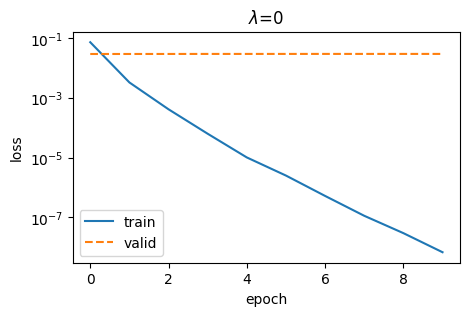

In [17]:
model_without = train(0)

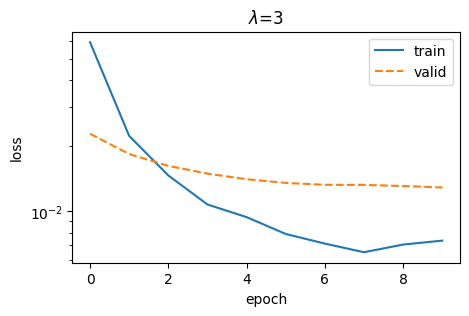

In [18]:
model_without = train(3)

$$
\mathcal{L}(\theta) + \frac{\lambda}{2}|\theta|^2
$$

$$
\nabla_\theta \mathcal{L}(\theta) + \lambda \theta
$$

$$
\theta \leftarrow \theta - \eta \left( \nabla_\theta \mathcal{L}(\theta) + \lambda \theta \right)
$$

$$
\theta \leftarrow (1 - \eta \lambda)\theta - \eta \nabla_\theta \mathcal{L}(\theta)
$$

정리하면 weight decay는 사실 weight에 L2 norm penalty를 준 건데 SGD에 한해서는 그냥 weight를 조금씩 줄여나가는거랑 완벽하게 동일하다.